## Running pre-trained models from Layout-Parser

Layout-Parser provides several models trained on datasets like Publaynet but from many different areas as well. 
In this tutorial we will show you how to configure and run a model from this library within a **dee**pdoctection pipeline. 

Layout-Parser provides some pre-trained Detectron2 models for various document layout analysis tasks. Models from other libraries are available as well, but running Detectron2 models with **deep**doctection is particularly easy because model wrappers are already available. 

You can find the Layout-Parser catalog [here](https://github.com/Layout-Parser/layout-parser/blob/main/src/layoutparser/models/detectron2/catalog.py) . 

Let's download `faster_rcnn_R_50_FPN_3x` trained on Publaynet. Enter the URL into your browser and the download starts. We need the model weights and the config file. 

To make it easy we suggest to save config file in **deep**doctection's .cache directory. 

Assume you have saved the model at: 

`~/.cache/deepdoctection/configs/layoutparser/publaynet/model_final.pth`

and the config file at:

`~/.cache/deepdoctection/weights/layoutparser/publaynet/config.yml`

In [10]:
import deepdoctection as dd
from matplotlib import pyplot as plt

## Adding model to the `ModelCatalog`

Next we will be adding the model to the `ModelCatalog`. This is not required but it simplifies a lot of things. 
You need to pass a key, e.g. `layoutparser/publaynet/model_final.pth` and a `ModelProfile`. A `ModelProfile` stores meta data about the model. Make sure that `ModelProfile.name` and `ModelProfile.config` is equal to the relative path of the model weights and the config file. 

It is convenient to add the categories. You can find the categories of the model [here](https://github.com/Layout-Parser/layout-parser/blob/main/src/layoutparser/models/detectron2/catalog.py) as well.  Note however, that, unlike in Layout-Parser all categories in deepdoctection start with 1. You therefore have to increment all category ids by 1. Also please ensure that all category ids are strings.  

In [8]:
dd.ModelCatalog.register("layoutparser/publaynet/model_final.pth",dd.ModelProfile(
            name="layoutparser/publaynet/model_final.pth",
            description="Add some infos regarding the model",
            config="layoutparser/publaynet/config.yml",
            tp_model=False,
            size = [],
            categories={
                "1": dd.LayoutType.text,
                "2": dd.LayoutType.title,
                "3": dd.LayoutType.list,
                "4": dd.LayoutType.table,
                "5": dd.LayoutType.figure,
            },
            model_wrapper="D2FrcnnDetector",
        ))

[0523 15:36.11 @detection_checkpoint.py:38]  INF  [DetectionCheckpointer] Loading from /home/janis/.cache/deepdoctection/weights/layoutparser/publaynet/model_final.pth ...
[0523 15:36.11 @checkpoint.py:150]  INF  [Checkpointer] Loading from /home/janis/.cache/deepdoctection/weights/layoutparser/publaynet/model_final.pth ...
|                                                                                                                                                                                              |14/?[00:00<00:00,26179.34it/s]
[0523 15:36.11 @doctectionpipe.py:84]  INF  Processing PMC1087887_00003.jpg
[0523 15:36.11 @context.py:126]  INF  ImageLayoutService total: 0.0383 sec.


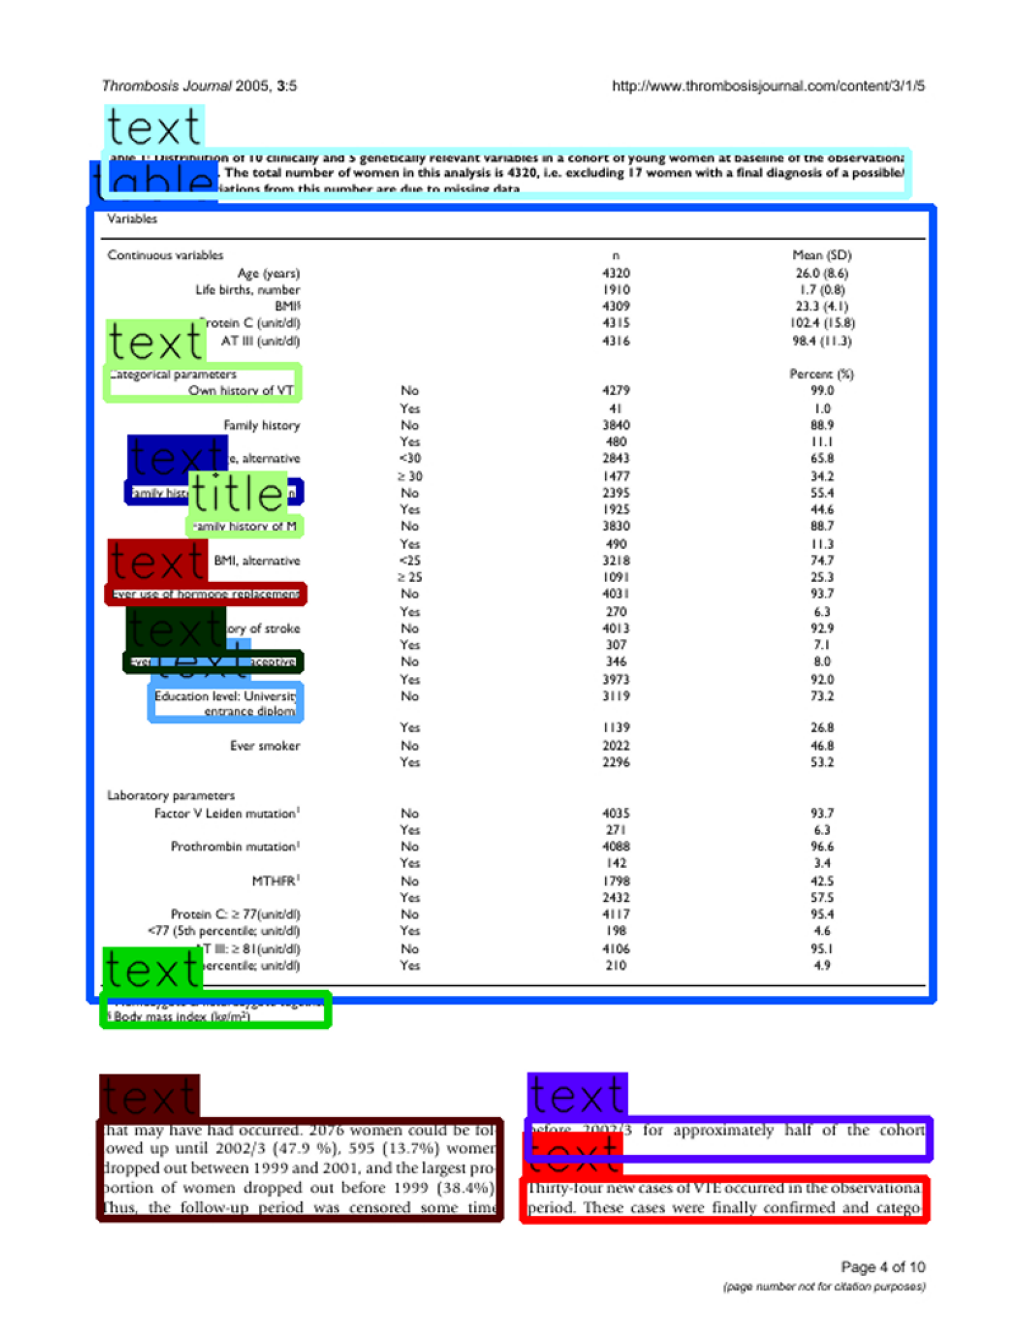

In [14]:
path_weights = dd.ModelCatalog.get_full_path_weights("layoutparser/publaynet/model_final.pth")
path_config = dd.ModelCatalog.get_full_path_configs("layoutparser/publaynet/model_final.pth")
categories = dd.ModelCatalog.get_profile("layoutparser/publaynet/model_final.pth").categories

d2_detector = dd.D2FrcnnDetector(path_config,path_weights,categories)
image_layout = dd.ImageLayoutService(d2_detector)

pipe = dd.DoctectionPipe([image_layout])

df = pipe.analyze(path="/home/janis/Downloads/publaynet")
df.reset_state()

df_iter = iter(df)
dp = next(df_iter)

image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(image)

You can use some additional config parameters that are only available in **deep**doctection like `NMS_THRESH_CLASS_AGNOSTIC`. This can reduce the number of overlapping layout segments.

[0523 15:40.14 @detection_checkpoint.py:38]  INF  [DetectionCheckpointer] Loading from /home/janis/.cache/deepdoctection/weights/layoutparser/publaynet/model_final.pth ...
[0523 15:40.14 @checkpoint.py:150]  INF  [Checkpointer] Loading from /home/janis/.cache/deepdoctection/weights/layoutparser/publaynet/model_final.pth ...
|                                                                                                                                                                                              |14/?[00:00<00:00,13665.41it/s]
[0523 15:40.14 @doctectionpipe.py:84]  INF  Processing PMC1087887_00003.jpg
[0523 15:40.14 @context.py:126]  INF  ImageLayoutService total: 0.0372 sec.


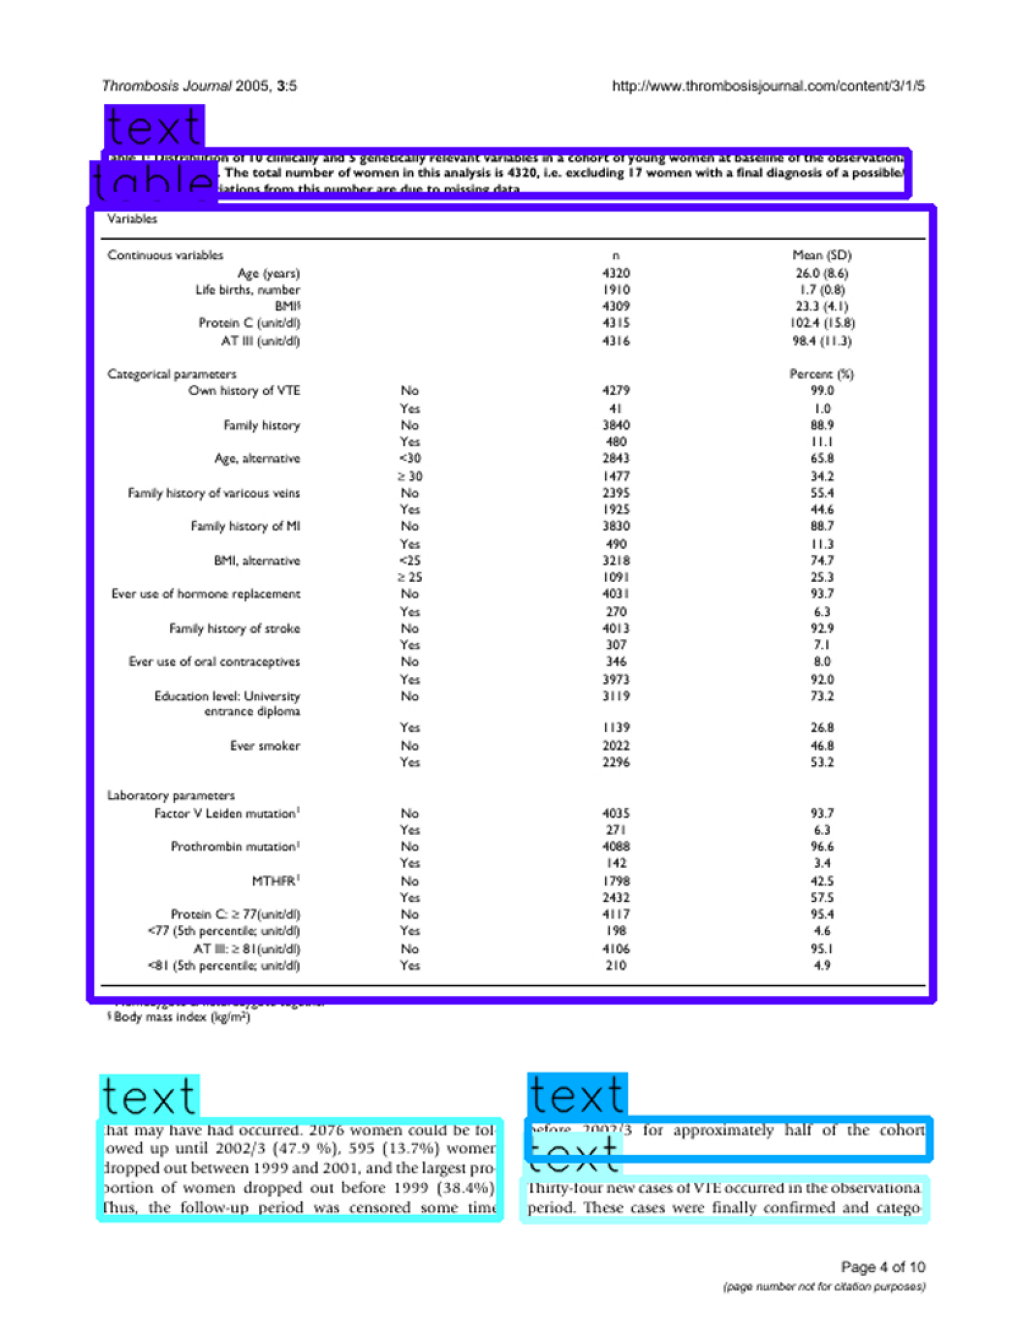

In [18]:
path_weights = dd.ModelCatalog.get_full_path_weights("layoutparser/publaynet/model_final.pth")
path_config = dd.ModelCatalog.get_full_path_configs("layoutparser/publaynet/model_final.pth")
categories = dd.ModelCatalog.get_profile("layoutparser/publaynet/model_final.pth").categories

d2_detector = dd.D2FrcnnDetector(path_config,path_weights,categories,config_overwrite=["NMS_THRESH_CLASS_AGNOSTIC=0.001"])
image_layout = dd.ImageLayoutService(d2_detector)

pipe = dd.DoctectionPipe([image_layout])

df = pipe.analyze(path="/path/to/publaynet")
df.reset_state()

df_iter = iter(df)
dp = next(df_iter)

image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(image)

## A second example

Let's have a look at a second example. We will be using the model trained on the NewspaperNavigator dataset. This dataset detects labels that have not been used in **deep**doctection before. As all categories are registered in a sub-class of `ObjectTypes` which in turn, is a sub-class of `Enum` we need to define a derived `ObjectTypes` class listing all new layout sections.   

In [21]:
@dd.object_types_registry.register("NewspaperType")
class NewspaperExtension(dd.ObjectTypes):
    """Additional Newspaper labels not registered yet"""

    photograph ="Photograph",
    illustration = "Illustration",
    map = "Map",
    comic = "Comics/Cartoon",
    editorial_cartoon = "Editorial Cartoon",
    headline = "Headline",
    advertisement =  "Advertisement"

There are two more things one needs to take care of.

1.) If we want to display the layout result we need to characterize the type of detected sections. There are several classes. Most of them are barely bounded layout components that only contain text and we call them `Layout` structures. There are other components as well, like `Table` which inherit a more complex structure like having `Cell`s. There is a dictionary `IMAGE_ANNOTATION_TO_LAYOUTS` available that maps the `Enum` members to the specific classes.

2.) When parsing the detected components into the `Page` format we need to add the components to the top level layout sections. While this not really important for the very small pipeline we have been creating, not adding them would also prevent the layout sections to be visualized.

In [25]:
from deepdoctection.datapoint.view import IMAGE_ANNOTATION_TO_LAYOUTS, Layout

IMAGE_ANNOTATION_TO_LAYOUTS.update({i: Layout for i in NewspaperExtension})

Everything else is pretty much straight forward.

In [ ]:
dd.ModelCatalog.register("layoutparser/newspaper/model_final.pth",dd.ModelProfile(
            name="layoutparser/newspaper/model_final.pth",
            description="layout detection ",
            config="layoutparser/newspaper/config.yml",
            size=[],
            tp_model=False,
            categories={"1": NewspaperExtension.photograph,
                        "2": NewspaperExtension.illustration,
                        "3": NewspaperExtension.map,
                        "4": NewspaperExtension.comic,
                        "5": NewspaperExtension.editorial_cartoon,
                        "6": NewspaperExtension.headline,
                        "7": NewspaperExtension.advertisement},
            model_wrapper="D2FrcnnDetector",
        ))

[0523 15:56.16 @detection_checkpoint.py:38]  INF  [DetectionCheckpointer] Loading from /home/janis/.cache/deepdoctection/weights/layoutparser/newspaper/model_final.pth ...
[0523 15:56.16 @checkpoint.py:150]  INF  [Checkpointer] Loading from /home/janis/.cache/deepdoctection/weights/layoutparser/newspaper/model_final.pth ...
|                                                                                                                                                                                                |2/?[00:00<00:00,2691.24it/s]
[0523 15:56.16 @doctectionpipe.py:84]  INF  Processing Screenshot_2023-05-11_12-48-18.png
[0523 15:56.16 @context.py:126]  INF  ImageLayoutService total: 0.0388 sec.


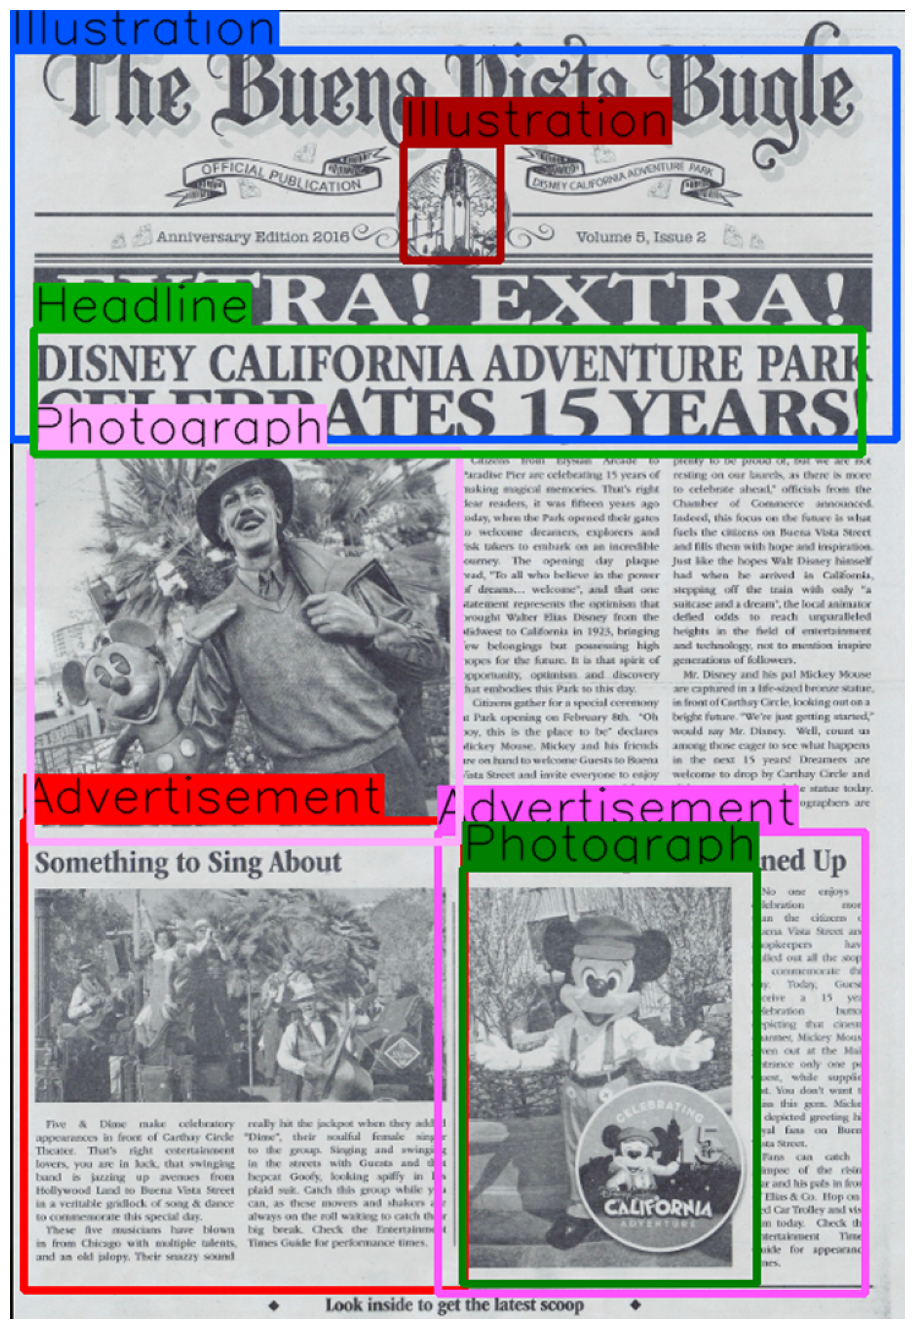

In [27]:
path_weights = dd.ModelCatalog.get_full_path_weights("layoutparser/newspaper/model_final.pth")
path_config = dd.ModelCatalog.get_full_path_configs("layoutparser/newspaper/model_final.pth")
categories = dd.ModelCatalog.get_profile("layoutparser/newspaper/model_final.pth").categories

d2_detector = dd.D2FrcnnDetector(path_config,path_weights,categories,config_overwrite=["NMS_THRESH_CLASS_AGNOSTIC=0.8","MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.1"])
image_layout = dd.ImageLayoutService(d2_detector)
pipe = dd.DoctectionPipe([image_layout])
pipe.page_parser._top_level_text_block_names.extend([layout_item for layout_item in NewspaperExtension])

df = pipe.analyze(path="/home/janis/Downloads/hflayout")
df.reset_state()

df_iter = iter(df)
dp = next(df_iter)

image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(image)

In [28]:
dp.layouts

[Layout(active=True, _annotation_id='5b0bd0dd-300c-3303-ad45-ffcb50ba5af8', category_name=<NewspaperExtension.headline>, _category_name=<NewspaperExtension.headline>, category_id='6', score=0.9875668287277222, sub_categories={}, relationships={}, bounding_box=BoundingBox(absolute_coords=True, ulx=14.930139541625977, uly=194.06497192382812, lrx=518.3706665039062, lry=270.4627685546875, height=76.39779663085938, width=503.4405269622803)),
 Layout(active=True, _annotation_id='b6bf8f1a-a62b-3958-8f9d-7c0dc7c79354', category_name=<NewspaperExtension.photograph>, _category_name=<NewspaperExtension.photograph>, category_id='1', score=0.9749446511268616, sub_categories={}, relationships={}, bounding_box=BoundingBox(absolute_coords=True, ulx=275.99072265625, uly=522.1495971679688, lrx=454.6565246582031, lry=775.3734741210938, height=253.223876953125, width=178.66580200195312)),
 Layout(active=True, _annotation_id='7fd1431f-4e48-3ff5-9fe9-be7c11c11bab', category_name=<NewspaperExtension.photogra